# Testing Mango

In [1]:
import sys
sys.path.append('/Users/sansan01/Learning/Bayesian_Learning/Exp-19/AutoTuner/')

In [2]:
from tuner import Tuner

In [3]:
from domain.distribution import loguniform

param_dict = {"changepoint_prior_scale": loguniform(-3, 1),
              'seasonality_prior_scale' : loguniform(1, 2)
             }

# userObjective

In [4]:
from classifiers.prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from classifiers.xgboosttree import Xgboosttree
import numpy as np

model = Xgboosttree()

X_train, y_train = model.load_train_dataset("../classifiers/data/PJME/train_data")
X_test, y_test = model.load_train_dataset("../classifiers/data/PJME/test_data")
X_validate, y_validate = model.load_train_dataset("../classifiers/data/PJME/validate_data")


count_called = 1

def objective_Prophet(args_list):
    global X_train, y_train,X_validate,y_validate, count_called
    
    print('count_called:',count_called)
    
    count_called = count_called + 1
    results = []
    for hyper_par in args_list:
        clf = Prophet(**hyper_par)
        clf.fit(X_train, y_train.ravel())
        y_pred = clf.predict(X_validate) 
        mse = mean_squared_error(y_validate, y_pred)
        mse = mse/10e5
        result =  (-1.0) * mse
        results.append(result)
    return results

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [5]:
conf_Dict = dict()
conf_Dict['batch_size'] = 1
conf_Dict['num_iteration'] = 20

# Defining Tuner

In [6]:
tuner_user = Tuner(param_dict, objective_Prophet,conf_Dict)

In [7]:
tuner_user.getConf()

{'param_dict': {'changepoint_prior_scale': <scipy.stats._distn_infrastructure.rv_frozen at 0x1a16021278>,
  'seasonality_prior_scale': <scipy.stats._distn_infrastructure.rv_frozen at 0x1a160217b8>},
 'userObjective': <function __main__.objective_Prophet(args_list)>,
 'domain_size': 5000,
 'initial_random': 1,
 'num_iteration': 20,
 'objective': 'maximize',
 'batch_size': 1}

In [8]:
import time
start_time = time.clock()

results = tuner_user.run()

end_time = time.clock()


print(end_time - start_time)

count_called: 1
count_called: 2
count_called: 3
count_called: 4
count_called: 5
count_called: 6
count_called: 7
count_called: 8
count_called: 9
count_called: 10
count_called: 11
count_called: 12
count_called: 13
count_called: 14
count_called: 15
count_called: 16
count_called: 17
count_called: 18
count_called: 19
count_called: 20
count_called: 21
208.06811


# Inspect the results

In [9]:
print('best hyper parameters:',results['best_hyper_parameter'])
print('best objective:',results['best_objective'])

best hyper parameters: {'changepoint_prior_scale': 0.003637027770387192, 'seasonality_prior_scale': 998.9615270129235}
best objective: -9.980570868699385


In [10]:
print('Sample hyper parameters tried:',len(results['hyper_parameters_tried']))
print(results['hyper_parameters_tried'][:2])

Sample hyper parameters tried: 21
[{'changepoint_prior_scale': 0.0020786819746552677, 'seasonality_prior_scale': 26.59714973171864}, {'changepoint_prior_scale': 0.001767171204879536, 'seasonality_prior_scale': 47.01649919978564}]


In [11]:
print('Sample objective values',len(results['objective_values']))
print(results['objective_values'][:5])

Sample objective values 21
[-10.127610915009532, -10.187643279822618, -9.980570868699385, -10.010228845600738, -10.067243730794846]


# Plotting the actual variation in objective values of the tried results

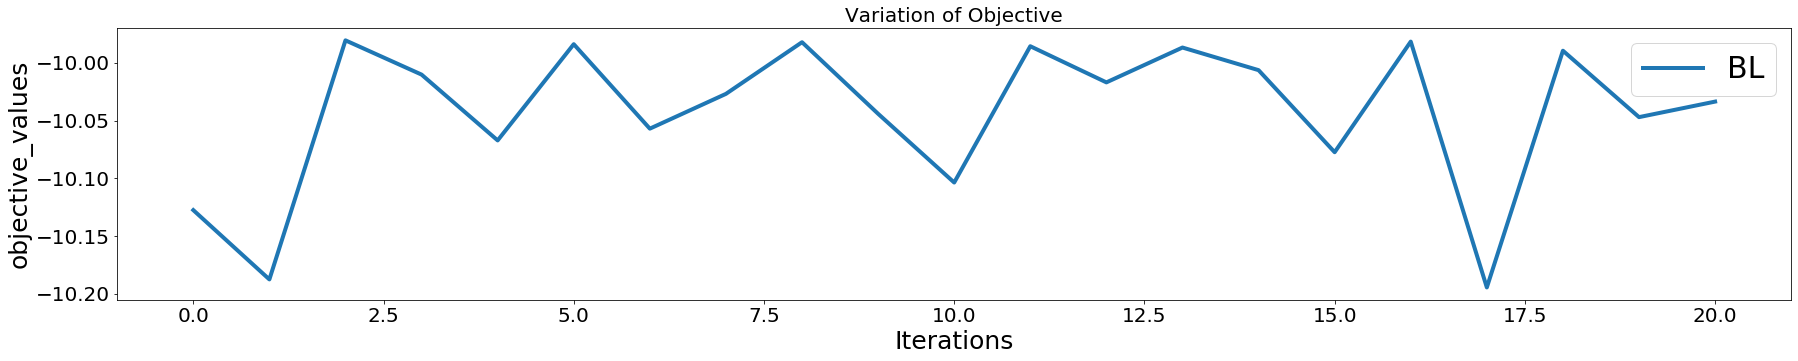

In [12]:
Size = 201 

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30,5))
plt.title('Variation of Objective',fontsize=20)
plt.plot(results['objective_values'][:Size],lw=4,label='BL')
plt.xlabel('Iterations', fontsize=25)
plt.ylabel('objective_values',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 30})
plt.show()

# Plotting the variation of Max objective values of the tried results

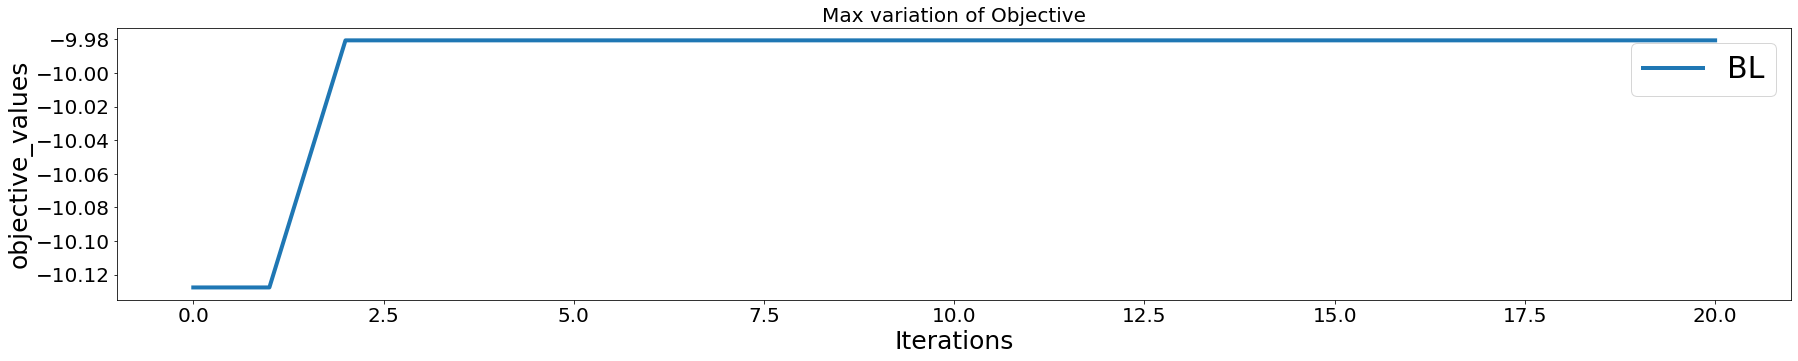

In [13]:
Size = 201 

import numpy as np

results_obj = np.array(results['objective_values'])

y_max=[]
for i in range(results_obj.shape[0]):
    y_max.append(np.max(results_obj[:i+1]))

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30,5))
plt.title('Max variation of Objective',fontsize=20)
plt.plot(y_max[:Size],lw=4,label='BL')
plt.xlabel('Iterations', fontsize=25)
plt.ylabel('objective_values',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 30})
plt.show()

# See the Result

In [14]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results)

{   'best_hyper_parameter': {   'changepoint_prior_scale': 0.003637027770387192,
                                'seasonality_prior_scale': 998.9615270129235},
    'best_objective': -9.980570868699385,
    'hyper_parameters_tried': [   {   'changepoint_prior_scale': 0.0020786819746552677,
                                      'seasonality_prior_scale': 26.59714973171864},
                                  {   'changepoint_prior_scale': 0.001767171204879536,
                                      'seasonality_prior_scale': 47.01649919978564},
                                  {   'changepoint_prior_scale': 0.003637027770387192,
                                      'seasonality_prior_scale': 998.9615270129235},
                                  {   'changepoint_prior_scale': 0.005849377459179194,
                                      'seasonality_prior_scale': 574.7097392126647},
                                  {   'changepoint_prior_scale': 0.009298854423519515,
                      

#  See the learned classifier result on the test data

In [15]:
model = Prophet(**results['best_hyper_parameter'])
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test) 

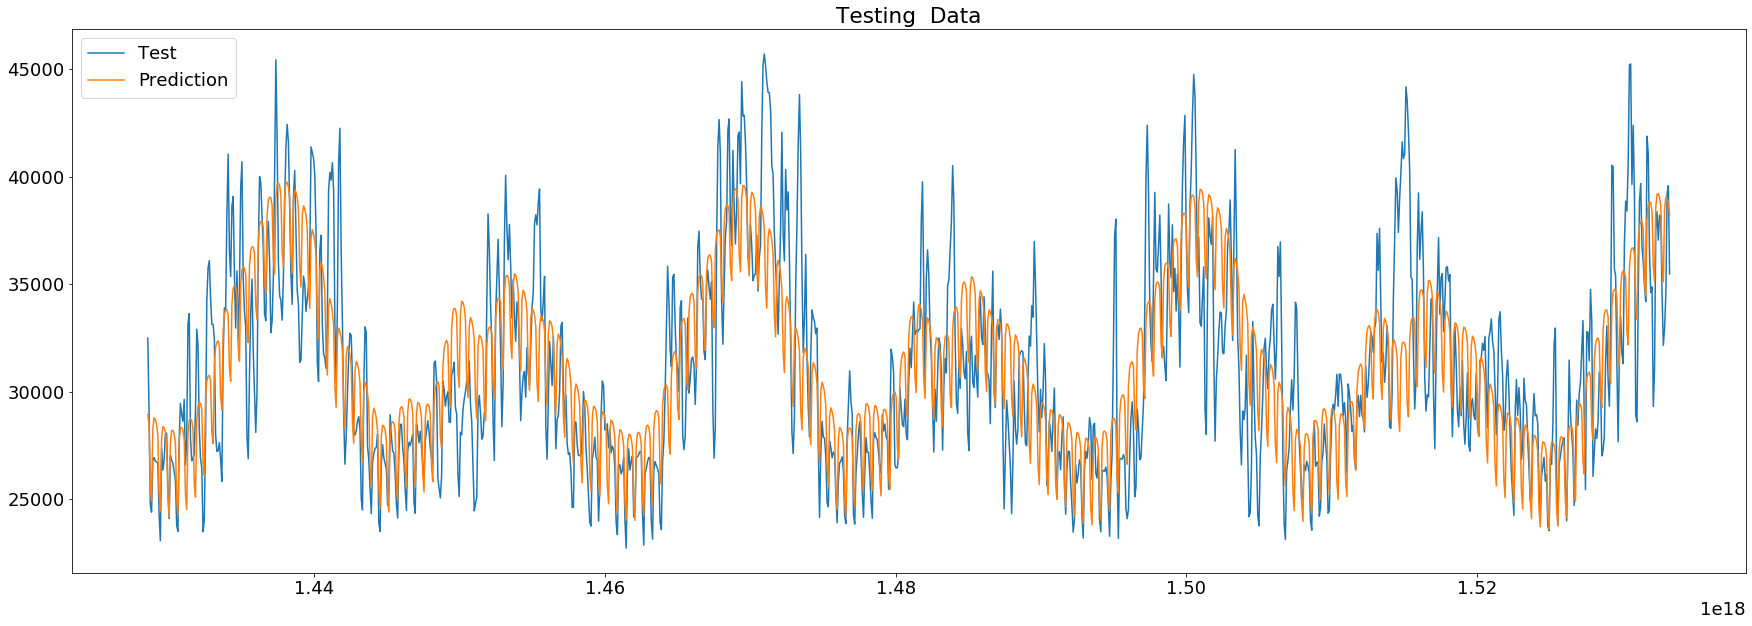

In [16]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})
plt.plot(X_test,y_test,label='Test')
plt.plot(X_test,y_pred,label='Prediction')
plt.title('Testing  Data')
plt.legend()
plt.show()

# All the Data

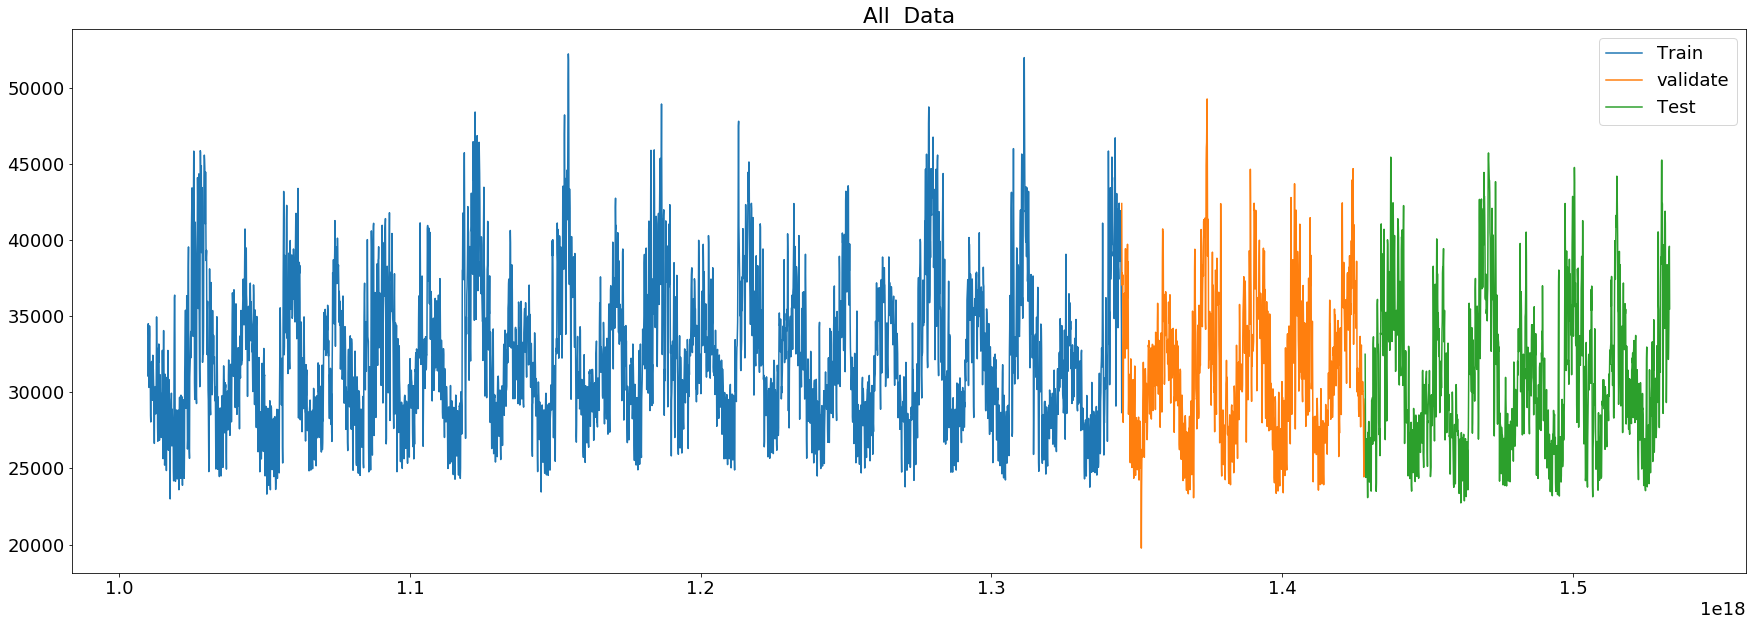

In [17]:
from classifiers.xgboosttree import Xgboosttree

model = Xgboosttree()

X_train, y_train = model.load_train_dataset("../classifiers/data/PJME/train_data")
X_test, y_test = model.load_train_dataset("../classifiers/data/PJME/test_data")
X_validate, y_validate = model.load_train_dataset("../classifiers/data/PJME/validate_data")

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})
plt.plot(X_train,y_train,label='Train')
plt.plot(X_validate,y_validate,label='validate')
plt.plot(X_test,y_test,label='Test')
plt.title('All  Data')
plt.legend()
plt.show()
